# **Projet de modélisation statistique**
*Tony Lauze - Amine Zarig*

## **1) Importation des données et statistiques descriptives**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Seminaire-modelisation-2A-ENSAE')

In [3]:
path = 'GWMF_Dataset.DAT'

In [4]:
df = pd.read_csv(path)
print(df.columns)
df = df[['abs_gwmf', 'tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd', 'balloon']]
df.columns

Index(['Unnamed: 0', 'tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd',
       'balloon', 'abs_gwmf'],
      dtype='object')


Index(['abs_gwmf', 'tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd',
       'balloon'],
      dtype='object')

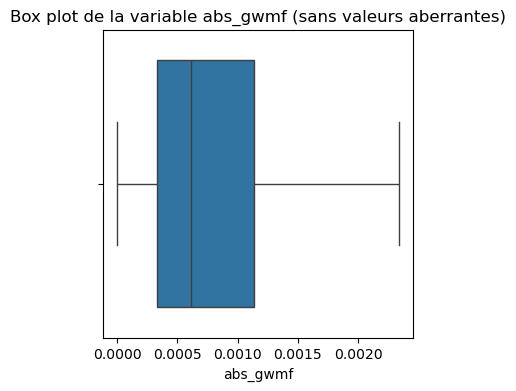

In [5]:
"""Distribution de la variable cible"""

plt.figure(figsize=(4, 4))
sns.boxplot(x='abs_gwmf', data=df, showfliers=False)
plt.title('Box plot de la variable abs_gwmf (sans valeurs aberrantes)')
plt.xlabel('abs_gwmf')
plt.show()


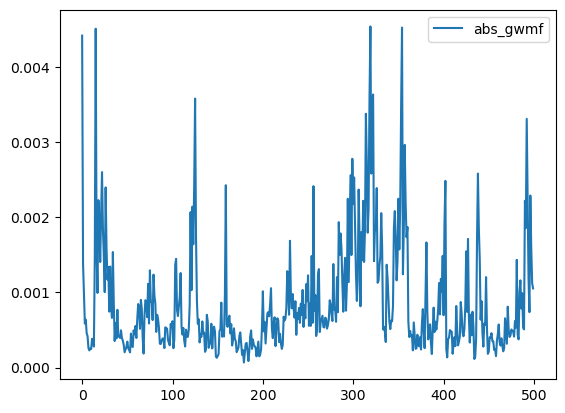

In [6]:
""" Graphique de la variable abs_gwmf """

def plot_abs(ballon, nb_obs):
    df_balloon1_500 = df.loc[df['balloon']==ballon].head(nb_obs)
    df_balloon1_500[['abs_gwmf']].plot()
    plt.show()

plot_abs(1,500)

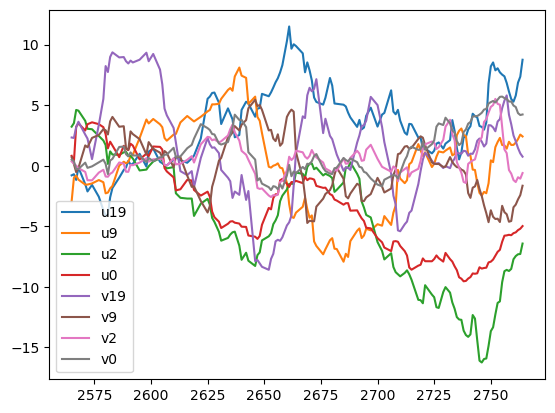

In [7]:
"""Plot des vents"""

def plot_vents(ballon, nb_obs):
    df_balloon1_500 = df.loc[df['balloon']==ballon].head(nb_obs)
    df_balloon1_500[['u19', 'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0']].plot()
    plt.show()

plot_vents(2,200)

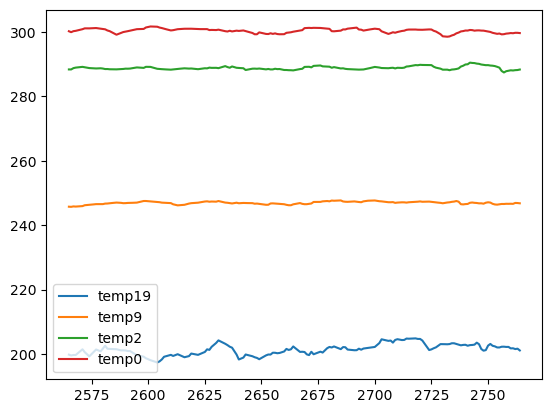

In [8]:
"""Plot des températures"""

def plot_temp(ballon, nb_obs):
    df_balloon1_500 = df.loc[df['balloon']==ballon].head(nb_obs)
    df_balloon1_500[['temp19', 'temp9', 'temp2', 'temp0']].plot()
    plt.show()

plot_temp(2,200)

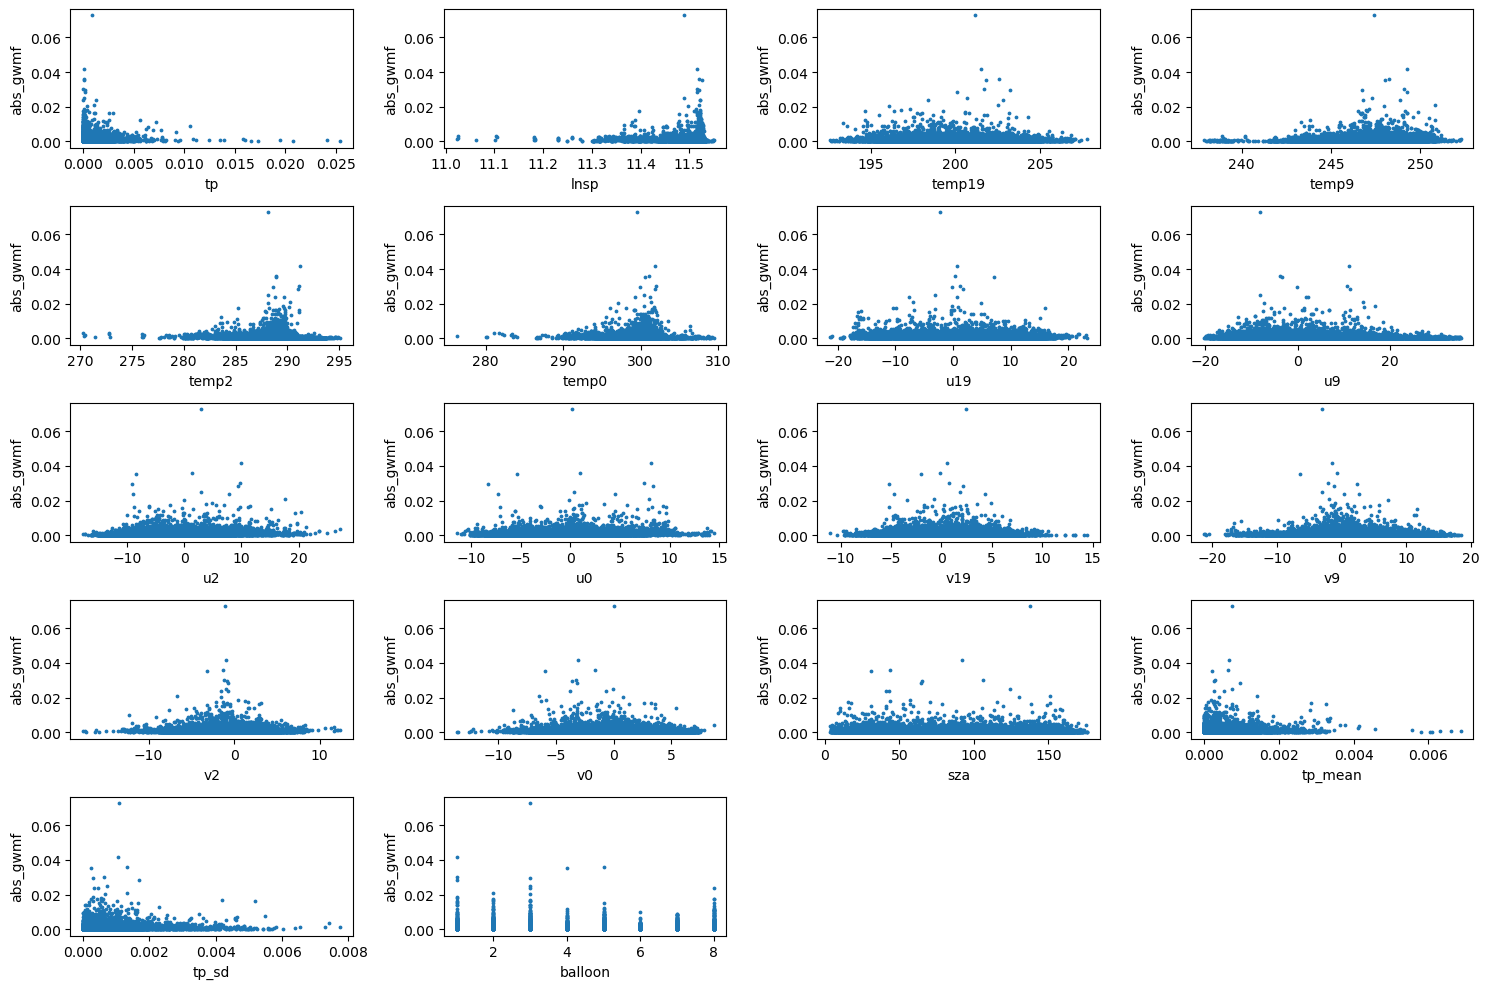

In [9]:
"""Observation des distributions"""

# Définir le nombre de colonnes pour organiser les graphiques
num_cols = 4
num_rows = (len(df.columns) - 1) // num_cols + 1

# Créer une nouvelle figure avec une taille spécifiée
plt.figure(figsize=(15, 10))

# Tracer les graphiques de dispersion pour chaque variable
for i, col in enumerate(df.columns.drop('abs_gwmf')):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.scatter(df[col], df['abs_gwmf'], s=3)  # Ajuster la taille des points ici    
    plt.xlabel(col)
    plt.ylabel('abs_gwmf')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.savefig('distribution_graphs.jpeg')  # Vous pouvez changer le format ici si besoin
plt.show()

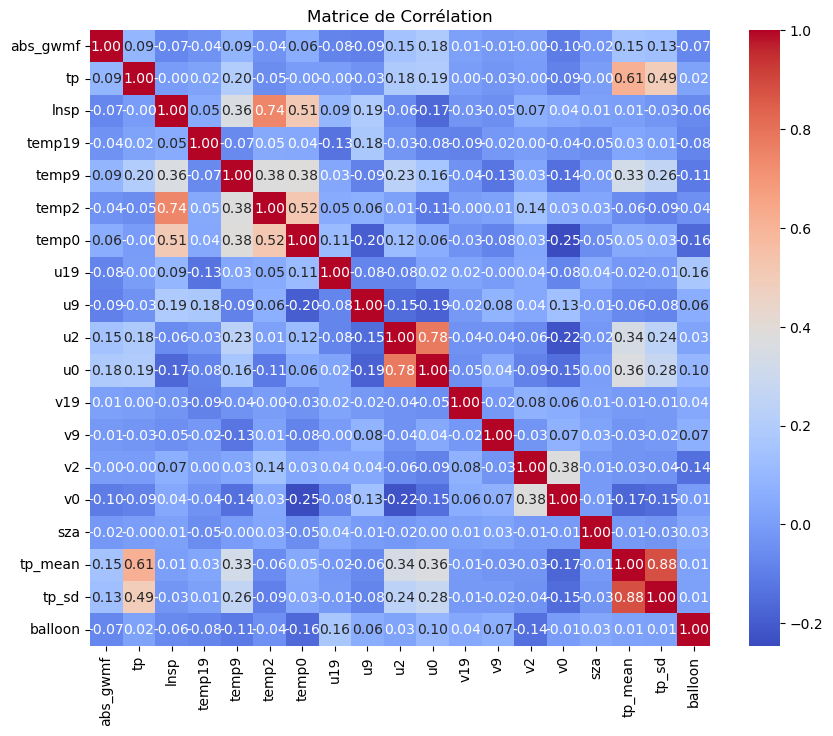

In [10]:
"""Matrice de corrélation des variables"""

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

# Créer un heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation')
plt.savefig('matrice_corr.jpeg')  # Vous pouvez changer le format ici si besoin
plt.show()

## **2) Modélisation : comparaison des approches paramétriques (régression, Lasso) et non-paramétriques (Random-Forest)**

In [11]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import add_dummy_feature
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [13]:
"""Normalisation des données"""

# Séparation des données en variables explicatives (X) et variable cible (y)
X = df.drop('abs_gwmf', axis=1)
y = df[['abs_gwmf', 'balloon']].copy()

# Exclure la colonne 'balloon' de la normalisation
X_to_scale = X.drop(columns=['balloon'])

# Normalisation des données sans la colonne 'balloon'
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_to_scale)

# Réintégrer la colonne 'balloon' dans les données normalisées
X_normalized = pd.concat([X[['balloon']], pd.DataFrame(X_normalized, columns=X_to_scale.columns, index=X_to_scale.index)], axis=1)

# Ajout d'une constante à X_normalized
X_normalized = sm.add_constant(X_normalized)

In [24]:
""" Entrainement d'une Random Forest avec validation croisée selon le ballon """

# Définir le nombre d'arbres dans le modèle de Random Forest
n_estimators = 100

# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=n_estimators)

# Définir les groupes pour la validation croisée
groups = X_normalized['balloon']

# Définir les plis de validation croisée en tenant compte des groupes
group_kfold = GroupKFold(n_splits=8)

# Liste pour stocker les scores de performance
mse_scores = []
rmse_scores = []
mae_scores = []

# Boucle sur les plis de validation croisée
for train_index, test_index in group_kfold.split(X_normalized, y, groups):
    X_train_fold, X_test_fold = X_normalized.iloc[train_index], X_normalized.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle sur les données d'entraînement
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Prédire sur les données de test
    y_pred_fold = rf_model.predict(X_test_fold)
    
    # Calculer les scores de performance
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
    
    # Ajouter les scores à la liste
    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)

# Calculer les scores moyens
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean MSE:", mean_mse)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

Mean MSE: 0.50000142878983
Mean RMSE: 0.7071077914926762
Mean MAE: 0.5004511431615761


In [31]:
def plot_prediction_RF_vs_actual(X_normalized, y, rf_model, balloon_number, num_observations):
    # Sélectionner les données du ballon spécifié
    X_balloon = X_normalized[X_normalized['balloon'] == balloon_number].head(num_observations)
    y_balloon = y[X_normalized['balloon'] == balloon_number].head(num_observations)

    # Prédire sur les données du ballon spécifié
    y_pred_balloon = rf_model.predict(X_balloon)

    # Créer un index de temps pour la série temporelle
    index_balloon = range(len(y_balloon))

    # Tracer la série temporelle des valeurs prédites et réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    plt.plot(index_balloon, y_balloon['abs_gwmf'], label='Valeurs réelles', linestyle='-', color='green')
    plt.plot(index_balloon, y_pred_balloon[:, 0], label='Valeurs prédites', linestyle='--', color='blue')
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    plt.title(f'Comparaison des prédictions (Random Forest) et des valeurs réelles pour le ballon {balloon_number}')
    plt.legend()
    plt.grid(True)
    plt.show()

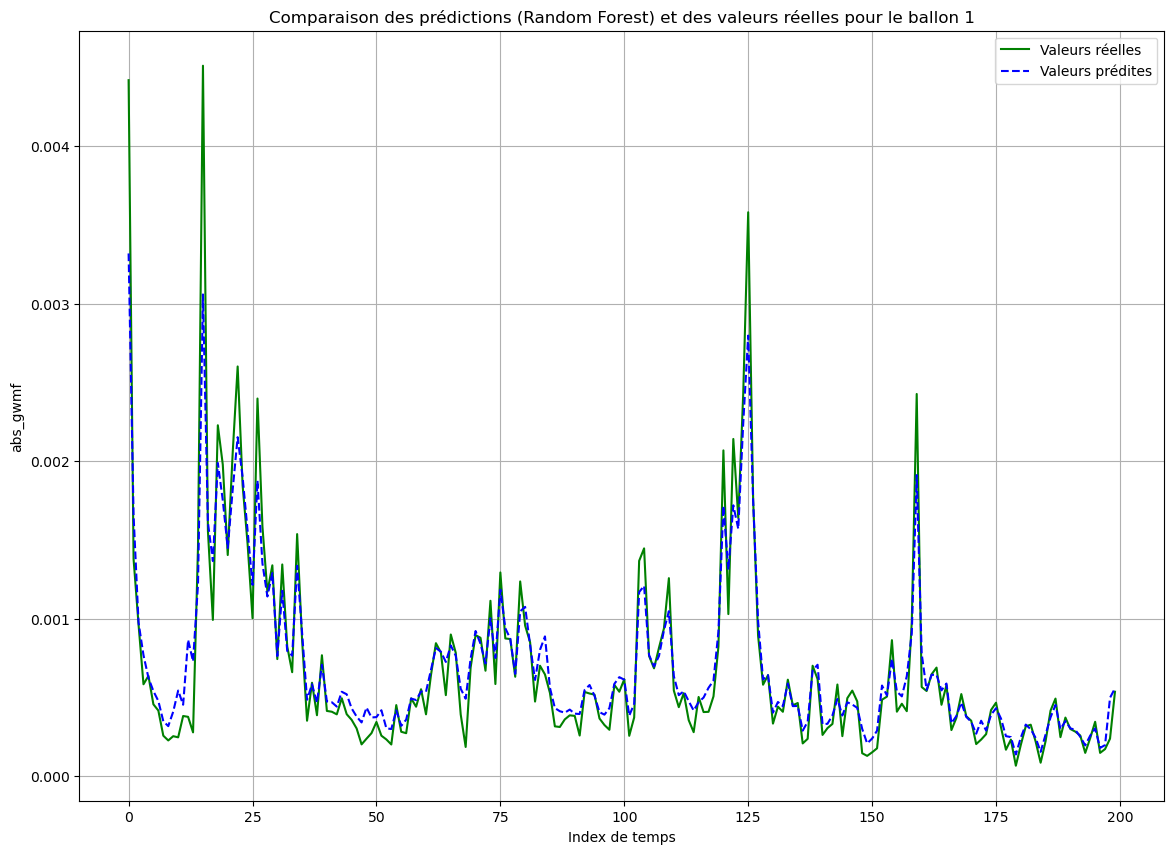

In [33]:
plot_prediction_RF_vs_actual(X_normalized, y, rf_model, balloon_number=1, num_observations=200)

In [14]:
""" Entrainement d'un modèle linéaire avec validation croisée selon le ballon """

# Initialiser le modèle Random Forest
linear_model = LinearRegression()

# Définir les groupes pour la validation croisée
groups = X_normalized['balloon']

# Définir les plis de validation croisée en tenant compte des groupes
group_kfold = GroupKFold(n_splits=8)

# Liste pour stocker les scores de performance
mse_scores = []
rmse_scores = []
mae_scores = []

# Boucle sur les plis de validation croisée
for train_index, test_index in group_kfold.split(X_normalized, y, groups):
    X_train_fold, X_test_fold = X_normalized.iloc[train_index], X_normalized.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle sur les données d'entraînement
    linear_model.fit(X_train_fold, y_train_fold)
    
    # Prédire sur les données de test
    y_pred_fold = linear_model.predict(X_test_fold)
    
    # Calculer les scores de performance
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
    
    # Ajouter les scores à la liste
    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)

# Calculer les scores moyens
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean MSE:", mean_mse)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

Mean MSE: 1.0636144533170708e-06
Mean RMSE: 0.0009812738785953245
Mean MAE: 0.0003402488138590139


In [35]:
def plot_prediction_linear_vs_actual(X_normalized, y, linear_model, balloon_number, num_observations):
    # Sélectionner les données du ballon spécifié
    X_balloon = X_normalized[X_normalized['balloon'] == balloon_number].head(num_observations)
    y_balloon = y[X_normalized['balloon'] == balloon_number].head(num_observations)

    # Prédire sur les données du ballon spécifié
    y_pred_balloon = linear_model.predict(X_balloon)

    # Créer un index de temps pour la série temporelle
    index_balloon = range(len(y_balloon))

    # Tracer la série temporelle des valeurs prédites et réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    plt.plot(index_balloon, y_balloon['abs_gwmf'], label='Valeurs réelles', linestyle='-', color='green')
    plt.plot(index_balloon, y_pred_balloon[:, 0], label='Valeurs prédites', linestyle='--', color='blue')
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    plt.title(f'Comparaison des prédictions (Modèle linéaire) avec les valeurs réelles pour le ballon {balloon_number}')
    plt.legend()
    plt.grid(True)
    plt.show()

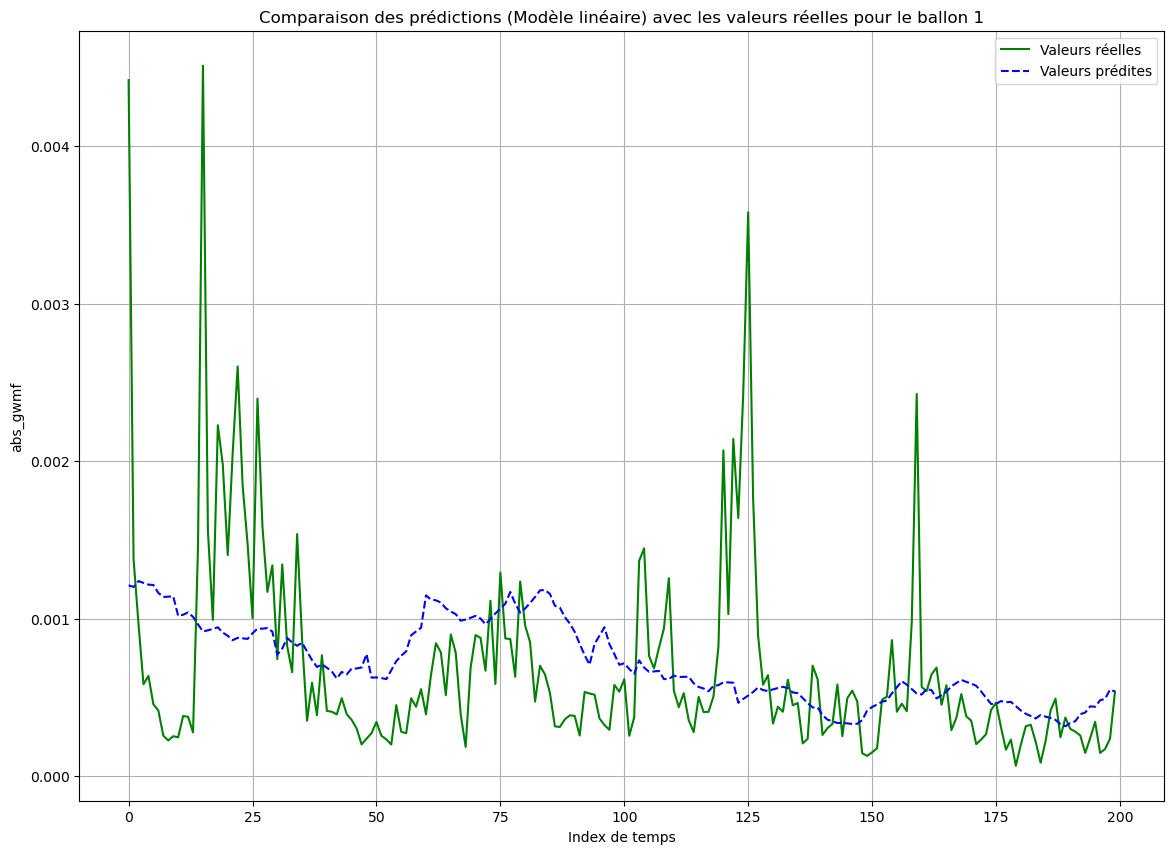

In [38]:
plot_prediction_linear_vs_actual(X_normalized, y, linear_model, balloon_number=1, num_observations=200)

In [50]:
"""Entrainement d'un modèle linéaire Lasso avec les features polynomiales en plus, jusqu'au degré 3"""

# Séparation des données en variables explicatives (X) et variable cible (y)
X = df.drop('abs_gwmf', axis=1)
y = df[['abs_gwmf', 'balloon']].copy()

# Exclure la colonne 'balloon' de la normalisation
X_to_scale = X.drop(columns=['balloon'])

# Normalisation des données sans la colonne 'balloon'
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_to_scale)

# Création des caractéristiques croisées
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_normalized)

# Réintégrer la colonne 'balloon' dans les données normalisées
X_poly = pd.concat([X[['balloon']], pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_to_scale.columns), index=X_to_scale.index)], axis=1)

# Ajout d'une constante à X_normalized
X_poly = sm.add_constant(X_poly)

In [ ]:
""" Entrainement du modèle selon le ballon """

# Initialiser le modèle Random Forest
lasso_model = LassoCV(cv=8, max_iter=20000, alphas=[1e-5, 1e-4, 1e-3])

# Définir les groupes pour la validation croisée
groups = X_poly['balloon']

# Définir les plis de validation croisée en tenant compte des groupes
group_kfold = GroupKFold(n_splits=8)

# Liste pour stocker les scores de performance
mse_scores = []
rmse_scores = []
mae_scores = []

# Boucle sur les plis de validation croisée
for train_index, test_index in group_kfold.split(X_poly, y, groups):
    X_train_fold, X_test_fold = X_poly.iloc[train_index], X_poly.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle sur les données d'entraînement
    lasso_model.fit(X_train_fold, y_train_fold['abs_gwmf'])
    
    # Prédire sur les données de test
    y_pred_fold = lasso_model.predict(X_test_fold)
    
    # Calculer les scores de performance
    mse_fold = mean_squared_error(y_test_fold['abs_gwmf'], y_pred_fold)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_test_fold['abs_gwmf'], y_pred_fold)
    
    # Ajouter les scores à la liste
    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)

# Calculer les scores moyens
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean MSE:", mean_mse)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

In [ ]:
def plot_prediction_lasso_polynomial_vs_actual(X_poly, y, lasso_model, balloon_number, num_observations):
    # Sélectionner les données du ballon spécifié
    X_balloon = X_poly[X_poly['balloon'] == balloon_number].head(num_observations)
    y_balloon = y[X_poly['balloon'] == balloon_number].head(num_observations)

    # Prédire sur les données du ballon spécifié
    y_pred_balloon = lasso_model.predict(X_balloon)

    # Créer un index de temps pour la série temporelle
    index_balloon = range(len(y_balloon))

    # Tracer la série temporelle des valeurs prédites et réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    plt.plot(index_balloon, y_balloon['abs_gwmf'], label='Valeurs réelles', linestyle='-', color='green')
    plt.plot(index_balloon, y_pred_balloon, label='Valeurs prédites', linestyle='--', color='blue')
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    plt.title(f'Prédiction (Modèle lasso sur features polynomiales) des valeurs pour le ballon {balloon_number}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_prediction_lasso_polynomial_vs_actual(X_poly, y, lasso_model, balloon_number=2, num_observations=200)

In [47]:
# Entraîner le modèle sur l'ensemble des données
lasso_model.fit(X_poly, y['abs_gwmf'])

# Obtenir les coefficients du modèle
lasso_coefs = lasso_model.coef_

# Afficher les caractéristiques sélectionnées par le modèle (celles avec des coefficients non nuls)
selected_features = X_poly.columns[lasso_coefs != 0]
print("Features sélectionnées par le modèle Lasso :", selected_features)


Features sélectionnées par le modèle Lasso : Index([], dtype='object')


In [262]:
""" Entraînement d'un réseau de neurones avec CV selon le ballon """

# Définir le nombre d'arbres dans le modèle de Random Forest
n_estimators = 100

# Initialiser le modèle séquentiel
model = Sequential()
model.add(Dense(100, input_dim=X_normalized.shape[1], activation='relu'))
model.add(Dense(1))

# Compiler le modèle avec une fonction de perte MSE et un optimiseur Adam
model.compile(loss='mean_squared_error', optimizer='adam')

# Définir les groupes pour la validation croisée
groups = X_normalized['balloon']

# Définir les plis de validation croisée en tenant compte des groupes
group_kfold = GroupKFold(n_splits=8)

# Liste pour stocker les scores de performance
mse_scores = []
rmse_scores = []
mae_scores = []

# Boucle sur les plis de validation croisée
for train_index, test_index in group_kfold.split(X_normalized, y, groups):
    X_train_fold, X_test_fold = X_normalized.iloc[train_index], X_normalized.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0)
    
    # Prédire sur les données de test
    y_pred_fold = model.predict(X_test_fold)
    
    # Calculer les scores de performance
    mse_fold = np.mean((y_pred_fold - y_test_fold.values)**2)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = np.mean(np.abs(y_pred_fold - y_test_fold.values))
    
    # Ajouter les scores à la liste
    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)

# Calculer les scores moyens
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

print("Mean MSE:", mean_mse)
print("Mean RMSE:", mean_rmse)
print("Mean MAE:", mean_mae)

/opt/mamba/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean MSE: 6.373082645127959
Mean RMSE: 2.2496163299639713
Mean MAE: 2.2495206805832684


In [268]:
def plot_prediction_RN_vs_actual(X_normalized, y, rf_model, balloon_number, num_observations):
    # Sélectionner les données du ballon spécifié
    X_balloon = X_normalized[X_normalized['balloon'] == balloon_number].head(num_observations)
    y_balloon = y[X_normalized['balloon'] == balloon_number].head(num_observations)

    # Prédire sur les données du ballon spécifié
    y_pred_balloon = model.predict(X_balloon)

    # Créer un index de temps pour la série temporelle
    index_balloon = range(len(y_balloon))

    # Tracer la série temporelle des valeurs prédites et réelles pour le ballon spécifié
    plt.figure(figsize=(14, 10))
    plt.plot(index_balloon, y_balloon['abs_gwmf'], label='Valeurs réelles', linestyle='-', color='green')
    plt.plot(index_balloon, y_pred_balloon[:, 0], label='Valeurs prédites', linestyle='--', color='blue')
    plt.xlabel('Index de temps')
    plt.ylabel('abs_gwmf')
    plt.title(f'Prédiction (Réseau de neurones) des valeurs pour le ballon {balloon_number}')
    plt.legend()
    plt.grid(True)
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


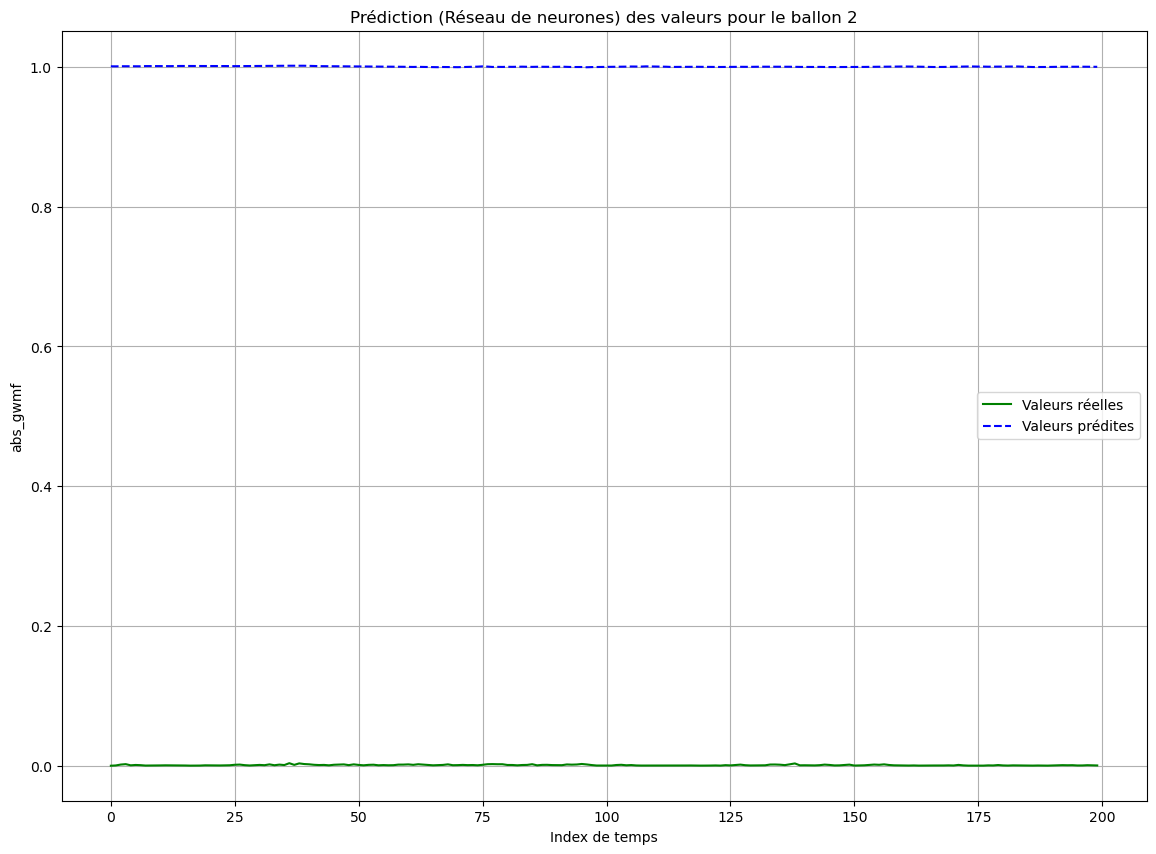

In [269]:
plot_prediction_RN_vs_actual(X_normalized, y, rf_model, balloon_number=2, num_observations=200)

In [124]:
"""Régression linéaire simple"""

def regression_lineaire_multivariable(dvf, variable_a_expliquer, variables_explicatives):    
    # Séparer la variable dépendante et les variables indépendantes
    y = dvf[variable_a_expliquer].copy()
    X = dvf[variables_explicatives].copy()

    column_names = X.columns
    
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=column_names)

    X = sm.add_constant(X)


    # Initialiser le modèle de régression linéaire avec des estimateurs de variance robustes
    model = sm.OLS(y, X).fit(cov_type='HC3')

    # Afficher les résultats de la régression
    print(model.summary())


In [229]:
var_base = ['tp', 'lnsp', 'temp19', 'temp9', 'temp2', 'temp0', 'u19',
       'u9', 'u2', 'u0', 'v19', 'v9', 'v2', 'v0', 'sza', 'tp_mean', 'tp_sd', 'balloon']

regression_lineaire_multivariable(df, 'abs_gwmf', var_base)

                            OLS Regression Results                            
Dep. Variable:               abs_gwmf   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     84.07
Date:                Wed, 13 Mar 2024   Prob (F-statistic):          1.00e-296
Time:                        17:12:30   Log-Likelihood:                 82364.
No. Observations:               16197   AIC:                        -1.647e+05
Df Residuals:                   16178   BIC:                        -1.645e+05
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010   1.18e-05     83.996      0.0

1.520328050121885e-06


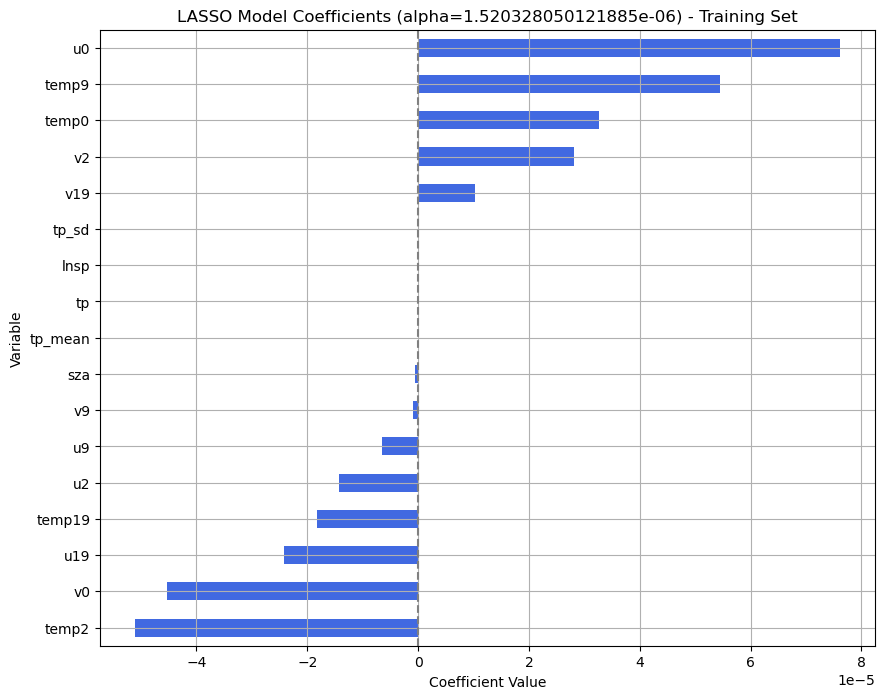

In [132]:
"""Régression LASSO"""

lasso_cv_model = models['Lasso Regression'].fit(X_train, y_train)

print(lasso_cv_model.alpha_)

# Extraire les coefficients du modèle Lasso
lasso_coefficients = pd.Series(lasso_cv_model.coef_, index=X_train.columns)

# Trier les coefficients par valeur
lasso_coefficients_sorted = lasso_coefficients.sort_values()

# Tracer un graphique de barres horizontales pour les coefficients
plt.figure(figsize=(10, 8))
lasso_coefficients_sorted.plot(kind='barh', color='royalblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title(f'LASSO Model Coefficients (alpha={lasso_cv_model.alpha_}) - Training Set')
plt.xlabel('Coefficient Value')
plt.ylabel('Variable')
plt.grid(True)
plt.show()

In [152]:
""" Récupération des variables choisies par l'algorithme random forest """

# Train the Random Forest model
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)

feature_names = X_train.columns
feature_importances = random_forest.feature_importances_

# Combine feature names and importances into a dictionary
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort feature importance dictionary by importance values (optional)
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature names and their importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

top_10_features = [feature for feature, importance in sorted_feature_importance[:10]]
top_10_features

u19: 0.1316480180795762
temp2: 0.07982095225601953
u0: 0.0787110992027122
tp_sd: 0.07532767756222691
lnsp: 0.0721329413426429
temp0: 0.057289518907097034
u2: 0.056413849806508494
temp19: 0.0562811636884862
sza: 0.05103293786497988
u9: 0.04902346009874214
v0: 0.047699520421028575
v9: 0.04678651722406743
v19: 0.04337603406202387
tp: 0.041147198635133005
temp9: 0.04027227342406471
tp_mean: 0.03680646615043026
v2: 0.03623037127426056


In [187]:
var_random_forest = ['u19', 'temp2', 'u0', 'tp_sd', 'lnsp', 'temp0', 'u2', 'temp19', 'sza', 'u9']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Définir les hyperparamètres à rechercher avec Randomized Search
random_params = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt'],
    'max_depth': randint(10, 100),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Créer un modèle Random Forest
rf = RandomForestRegressor(random_state=42)

# Recherche aléatoire des meilleurs hyperparamètres
random_search = RandomizedSearchCV(rf, param_distributions=random_params, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Obtenez les meilleurs paramètres trouvés par Randomized Search
best_random_params = random_search.best_params_

# Définir une grille plus précise autour des meilleurs paramètres trouvés
param_grid = {
    'n_estimators': [best_random_params['n_estimators'] - 50, best_random_params['n_estimators'], best_random_params['n_estimators'] + 50],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [best_random_params['max_depth'] - 10, best_random_params['max_depth'], best_random_params['max_depth'] + 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Recherche en grille des meilleurs hyperparamètres autour des meilleurs paramètres trouvés par Randomized Search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtenez les meilleurs paramètres trouvés par Grid Search
best_params = grid_search.best_params_

# Créer un nouveau modèle Random Forest avec les meilleurs paramètres
best_rf_model = RandomForestRegressor(**best_params)


In [188]:
"""Initialisation des modèles à comparer"""

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': LassoCV(cv=KFold(n_splits=10, shuffle=True, random_state=42)),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'KNN' : KNeighborsRegressor()
}

In [163]:
"""Entrainement des modèles et stockage des erreurs RMSE"""

# Dictionnaire pour stocker les erreurs RMSE pour chaque modèle
rmse_errors = {name: [] for name in models}

# Sélectionner les variables pour KNN
X_train_knn = X_train[var_random_forest]

# Dictionnaire pour stocker les erreurs RMSE pour chaque modèle
rmse_errors = {name: [] for name in models}

# Boucle sur chaque modèle
for name, model in models.items():
    if name == 'KNN':
        # Utiliser seulement les variables sélectionnées pour KNN
        rmse_scores = cross_val_score(model, X_train_knn, y_train, cv=10, scoring='neg_root_mean_squared_error')
    else:
        # Utiliser toutes les variables pour les autres modèles
        rmse_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
    
    rmse_errors[name] = -rmse_scores  # Convertir en valeurs positives

In [191]:
"""Autres erreurs"""
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_val_predict


# Dictionnaire pour stocker les autres métriques d'évaluation
other_metrics = {name: {'MAE': [], 'MAPE': [], 'R^2': [], 'Max Absolute Error': []} for name in models}

# Boucle sur chaque modèle
for name, model in models.items():
    if name == 'KNN':
        # Utiliser seulement les variables sélectionnées pour KNN
        predictions = cross_val_predict(model, X_train_knn, y_train, cv=10)
    else:
        # Utiliser toutes les variables pour les autres modèles
        predictions = cross_val_predict(model, X_train, y_train, cv=10)
    
    # Calculer les métriques d'évaluation
    mae = mean_absolute_error(y_train, predictions)
    mape = mean_absolute_percentage_error(y_train, predictions)
    r2 = r2_score(y_train, predictions)
    max_absolute_error = max(np.abs(y_train - predictions))
    
    # Stocker les métriques dans le dictionnaire
    other_metrics[name]['MAE'] = mae
    other_metrics[name]['MAPE'] = mape
    other_metrics[name]['R^2'] = r2
    other_metrics[name]['Max Absolute Error'] = max_absolute_error

In [195]:

# Convertir le dictionnaire other_metrics en DataFrame
other_metrics_df = pd.DataFrame(other_metrics)
    


In [196]:
other_metrics_df.head()

,Linear Regression,Lasso Regression,Random Forest,Gradient Boosting,KNN
MAE,6.832559e-04,6.869844e-04,5.495080e-04,6.343848e-04,7.406813e-04
MAPE,1.100738e+11,1.063347e+11,1.111608e+11,1.122954e+11,9.489124e+10
R^2,6.212335e-02,5.841916e-02,2.751838e-01,1.403978e-01,-9.970099e-02
Max Absolute Error,7.137646e-02,7.146695e-02,7.011622e-02,7.139835e-02,7.145819e-02


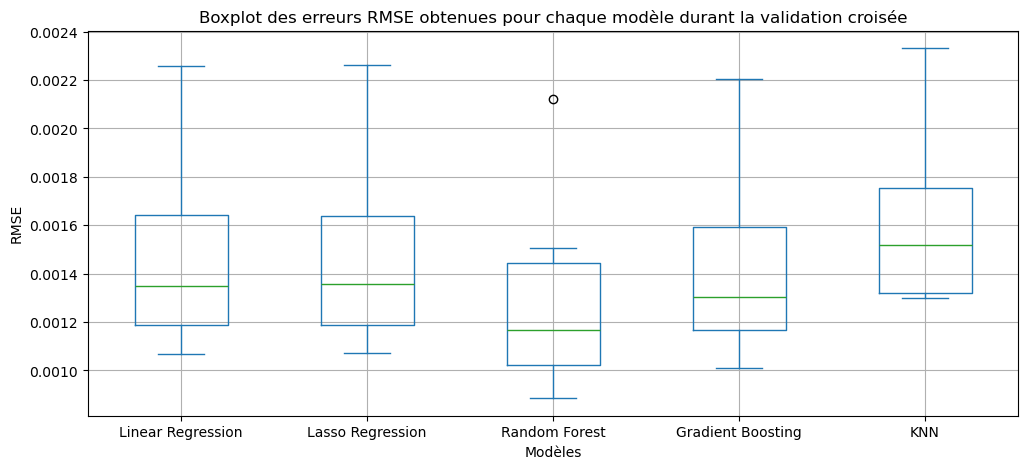

In [164]:
"""Observation de la distribution des erreurs pour chaques modèles"""

scores = pd.DataFrame(rmse_errors)

# Tracer un boxplot pour la variation des valeurs RMSE pour chaque modèle
scores.plot(kind='box', 
            title='Boxplot des erreurs RMSE obtenues pour chaque modèle durant la validation croisée',
            figsize=(12, 5))
plt.ylabel('RMSE')
plt.xlabel('Modèles')
plt.grid(True)
plt.show()